# 🩺 TabPFN Features — NaN Analizi & Sütun Temizliği

`tabpfn_features.csv` dosyasını okur, NaN oranlarını kontrol eder,
**%50'den fazla** NaN olan sütunları çıkarır ve temiz CSV'yi kaydeder.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ── Paths ────────────────────────────────────────────────────────────────
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
CSV_PATH = PROJECT_ROOT / "data" / "processed" / "tabpfn_features.csv"
CLEAN_CSV = PROJECT_ROOT / "data" / "processed" / "tabpfn_features_clean.csv"

NAN_THRESHOLD = 0.50  # %50'den fazla NaN → sütunu sil

df = pd.read_csv(CSV_PATH)
print(f"📂 Yüklendi: {CSV_PATH.name}")
print(f"   Shape: {df.shape[0]:,} satır × {df.shape[1]} sütun\n")

📂 Yüklendi: tabpfn_features.csv
   Shape: 4,479 satır × 18 sütun



## 📊 NaN Oranları (Tüm Sütunlar)

In [2]:
# NaN istatistikleri
nan_stats = pd.DataFrame({
    "NaN Sayısı": df.isna().sum(),
    "NaN Oranı (%)": (df.isna().mean() * 100).round(2),
    "Dolu Sayısı": df.notna().sum(),
}).sort_values("NaN Oranı (%)", ascending=False)

nan_stats

,NaN Sayısı,NaN Oranı (%),Dolu Sayısı
glu_first_emerg,4432,98.95,47
pulse_pressure,1466,32.73,3013
bp_min_first_emerg,1466,32.73,3013
shock_index,1465,32.71,3014
bp_max_first_emerg,1465,32.71,3014
bp_min_last_emerg,1267,28.29,3212
bp_max_last_emerg,1264,28.22,3215
temp_drop,1109,24.76,3370
temp_first_emerg,992,22.15,3487
temp_last_emerg,835,18.64,3644


## 📉 NaN Oranı Görselleştirme

/var/folders/pv/pr_x9g556yxg3mhjg9g3hwj80000gn/T/ipykernel_23029/3870161704.py:13: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/pv/pr_x9g556yxg3mhjg9g3hwj80000gn/T/ipykernel_23029/3870161704.py:14: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.savefig(PROJECT_ROOT / "data" / "processed" / "nan_analysis.png", dpi=150)
/Users/enesdemir/Documents/time-multimodal/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


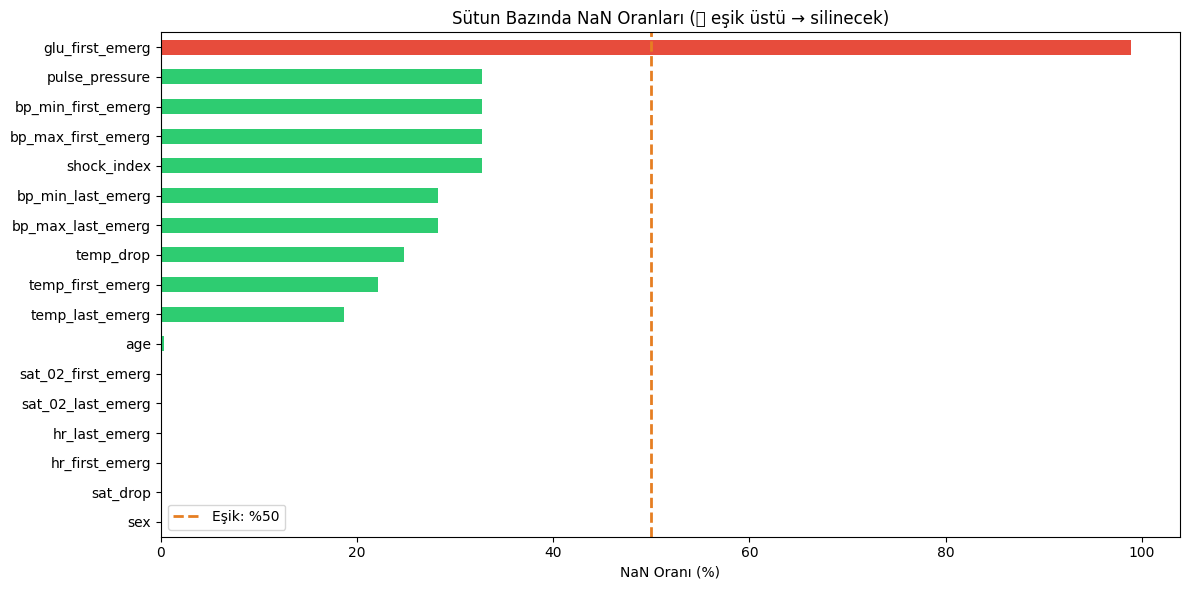

📸 Grafik kaydedildi: data/processed/nan_analysis.png


In [3]:
fig, ax = plt.subplots(figsize=(12, 6))

nan_pct = df.drop(columns=["patient_id"]).isna().mean() * 100
nan_pct = nan_pct.sort_values(ascending=True)

colors = ["#e74c3c" if v > NAN_THRESHOLD * 100 else "#2ecc71" for v in nan_pct.values]

nan_pct.plot.barh(ax=ax, color=colors)
ax.axvline(x=NAN_THRESHOLD * 100, color="#e67e22", linestyle="--", linewidth=2, label=f"Eşik: %{NAN_THRESHOLD*100:.0f}")
ax.set_xlabel("NaN Oranı (%)")
ax.set_title("Sütun Bazında NaN Oranları (🔴 eşik üstü → silinecek)")
ax.legend()
plt.tight_layout()
plt.savefig(PROJECT_ROOT / "data" / "processed" / "nan_analysis.png", dpi=150)
plt.show()
print("📸 Grafik kaydedildi: data/processed/nan_analysis.png")

## 🗑️ Yüksek NaN Oranına Sahip Sütunların Silinmesi

In [4]:
# patient_id hariç, NaN oranı eşiğin üstünde olan sütunları bul
feature_cols = [c for c in df.columns if c != "patient_id"]
nan_ratio = df[feature_cols].isna().mean()

cols_to_drop = nan_ratio[nan_ratio > NAN_THRESHOLD].index.tolist()

if cols_to_drop:
    print(f"🗑️  Silinecek sütunlar (NaN > %{NAN_THRESHOLD*100:.0f}):")
    for col in cols_to_drop:
        pct = nan_ratio[col] * 100
        print(f"   ❌ {col:30s} → %{pct:.1f} NaN")

    df_clean = df.drop(columns=cols_to_drop)
else:
    print("✅ Hiçbir sütun eşiği aşmıyor, silme yapılmadı.")
    df_clean = df.copy()

print(f"\n📐 Temiz shape: {df_clean.shape[0]:,} satır × {df_clean.shape[1]} sütun")

🗑️  Silinecek sütunlar (NaN > %50):
   ❌ glu_first_emerg                → %99.0 NaN

📐 Temiz shape: 4,479 satır × 17 sütun


## 💾 Temiz CSV Kaydet

In [5]:
df_clean.to_csv(CLEAN_CSV, index=False)
print(f"✅ Kaydedildi → {CLEAN_CSV}")

# Son durum
print(f"\n📋 Kalan sütunlar ({df_clean.shape[1]}):")
for col in df_clean.columns:
    nan_pct_val = df_clean[col].isna().mean() * 100
    print(f"   {'✅' if nan_pct_val < 10 else '⚠️'} {col:30s} → %{nan_pct_val:.1f} NaN")

✅ Kaydedildi → /Users/enesdemir/Documents/time-multimodal/data/processed/tabpfn_features_clean.csv

📋 Kalan sütunlar (17):
   ✅ patient_id                     → %0.0 NaN
   ✅ age                            → %0.3 NaN
   ✅ sex                            → %0.0 NaN
   ⚠️ temp_first_emerg               → %22.1 NaN
   ✅ hr_first_emerg                 → %0.0 NaN
   ⚠️ bp_max_first_emerg             → %32.7 NaN
   ⚠️ bp_min_first_emerg             → %32.7 NaN
   ✅ sat_02_first_emerg             → %0.0 NaN
   ⚠️ temp_last_emerg                → %18.6 NaN
   ✅ sat_02_last_emerg              → %0.0 NaN
   ✅ hr_last_emerg                  → %0.0 NaN
   ⚠️ bp_max_last_emerg              → %28.2 NaN
   ⚠️ bp_min_last_emerg              → %28.3 NaN
   ⚠️ temp_drop                      → %24.8 NaN
   ✅ sat_drop                       → %0.0 NaN
   ⚠️ shock_index                    → %32.7 NaN
   ⚠️ pulse_pressure                 → %32.7 NaN
